In [1]:
import pandas as pd
from data_process.preprocessing import discretization, get_nodes_type, code_categories
from block_learning.train_bn import structure_learning, parameter_learning
from block_learning.partial_bn_train import connect_partial_bn, hierarchical_train, direct_connect, direct_train
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from block_learning.save_bn import save_structure, save_params
from block_learning.read_bn import read_structure, read_params
from block_learning.sampling import generate_synthetics, get_probability
from libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import visualizer, draw_comparative_hist
import networkx as nx
from pomegranate import log_probability, BayesianNetwork
from libpgm.sampleaggregator import SampleAggregator

In [2]:
data = pd.read_csv('data/final_dataset_no_posts_info.csv')
data.head(10)

,age,age_hidden,has_high_education,is_closed,len_of_about,len_of_status,number_of_activities,number_of_books,number_of_followers,number_of_friends,...,driver,has_pets,cash_usage,gulyaka,zhavoronok,sum_act,top1,top2,top3,top4
0,34,0.0,1,0,14,16,1,1,720,911,...,0,0,0,1,0,1,Gifts & holidays,Music,History & politics,Purchase & sale
1,0,1.0,0,0,0,0,0,0,87638,687,...,1,0,0,1,0,2,Gifts & holidays,History & politics,Love & relation,Music
2,37,0.0,0,0,0,2,0,0,0,24,...,0,1,0,0,0,1,Purchase & sale,Gifts & holidays,Cooking,Love & relation
3,39,0.0,1,0,0,11,1,1,317,291,...,0,0,0,1,0,2,History & politics,Gifts & holidays,Love & relation,Job & money
4,34,0.0,0,0,0,11,0,0,328,413,...,0,0,0,1,0,1,Gifts & holidays,Music,History & politics,Love & relation
5,36,0.0,0,0,0,0,0,0,474,175,...,1,0,0,0,0,1,Gifts & holidays,History & politics,Love & relation,Fitness & cosmetology
6,0,1.0,0,0,0,3,0,0,7458,982,...,0,1,0,1,0,2,Gifts & holidays,Music,History & politics,Purchase & sale
7,35,0.0,0,0,0,0,0,0,2659,279,...,1,0,0,0,0,1,Gifts & holidays,History & politics,Music,Purchase & sale
8,41,0.0,0,0,0,0,0,0,651,134,...,1,0,0,0,0,1,Gifts & holidays,Love & relation,History & politics,Purchase & sale
9,34,0.0,1,0,0,4,1,4,1522,177,...,1,0,0,0,0,2,Gifts & holidays,Love & relation,History & politics,Cooking


In [3]:
data = data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives','len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1','top2','top3','top4', 'nodes',	'betweenness_centrality',	'density',	'eigenvector_centrality',	'degree_assortativity_coefficient','max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']] #'posts_count',	'posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']]

In [4]:
data.shape

(51478, 25)

In [5]:
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [6]:
data.shape

(51371, 25)

In [7]:
discrete_data = discretization(data, 'equal_frequency', bins= 5, columns=['betweenness_centrality',	'density',	'eigenvector_centrality',	'degree_assortativity_coefficient','max_tr', 'mean_tr'])#, 'posts_per_month', 'repost_ratio'])

In [8]:
new_data = code_categories(discrete_data, ['top1', 'top2', 'top3', 'top4'])

In [9]:
module1 = new_data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']]
module2 = new_data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']]
module3 = new_data[['top1', 'top2', 'top3', 'top4']]
module4 = new_data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient']]
module5 = new_data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']]
#module6 = new_data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']]

In [10]:
node_type1 = get_nodes_type(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']])
node_type1

{'age': 'disc',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation_status': 'disc',
 'number_of_relatives': 'disc'}

In [11]:
node_type2 = get_nodes_type(data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']])
node_type2

{'len_of_about': 'disc',
 'number_of_activities': 'disc',
 'number_of_books': 'disc',
 'number_of_interests': 'disc',
 'number_of_movies': 'disc'}

In [12]:
node_type3 = get_nodes_type(data[['top1', 'top2', 'top3', 'top4']])
node_type3

{'top1': 'disc', 'top2': 'disc', 'top3': 'disc', 'top4': 'disc'}

In [13]:
node_type4 = get_nodes_type(data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient']])
node_type4

{'nodes': 'disc',
 'betweenness_centrality': 'cont',
 'eigenvector_centrality': 'cont',
 'density': 'cont',
 'degree_assortativity_coefficient': 'cont'}

In [14]:
node_type5 = get_nodes_type(data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']])
node_type5

{'max_tr': 'cont',
 'mean_tr': 'cont',
 'parent': 'disc',
 'driver': 'disc',
 'has_pets': 'disc',
 'cash_usage': 'disc'}

In [15]:
#node_type6 = get_nodes_type(data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']])
#node_type6

In [16]:
start = time.time()
node_type = {**node_type1, **node_type2, **node_type3, **node_type4, **node_type5}
bn = structure_learning(new_data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives','len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1', 'top2', 'top3', 'top4','nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient', 'max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']], 'K2', node_type)
param = parameter_learning(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives','len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1', 'top2', 'top3', 'top4','nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient','max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']], node_type, bn)
end = time.time()
print(end - start)

  0%|          | 51/1000000 [01:45<575:40:26,  2.07s/it]118.1953775882721


In [17]:
save_structure(bn, 'full_net')
skel = read_structure('full_net')
save_params(param, 'full_net_param')
params = read_params('full_net_param')
full = HyBayesianNetwork(skel, params)

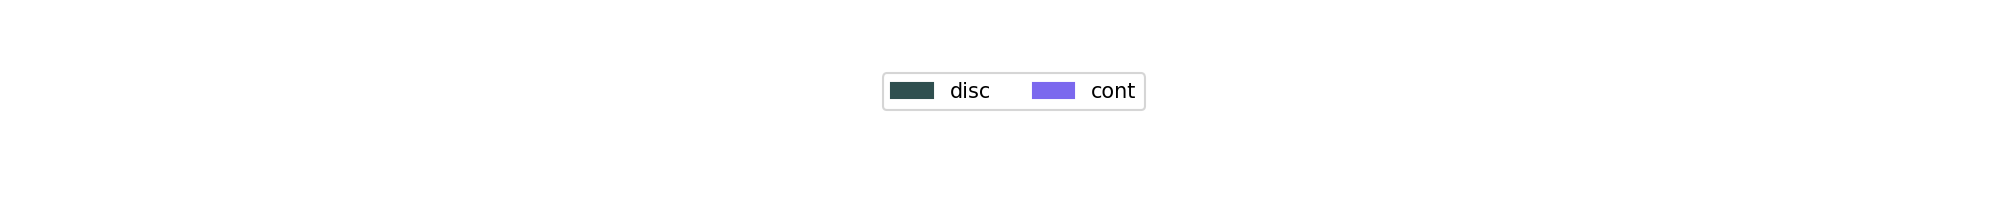

In [18]:
visualizer(bn, node_type, 'Full_net')

In [19]:
data_filter = data.loc[(data['age']>=50)&(data['age']<=70)& (data['sex']==1)]

In [20]:
data_filter.reset_index(inplace=True, drop=True)
data_filter.shape

(4581, 25)

In [21]:
sample = pd.DataFrame()

In [22]:
for i in range (1000):
    age = np.random.randint(50,71,1)[0]
    evidence = {'age':str(age), 'sex':'1'}
    batch = pd.DataFrame(full.randomsample(5,evidence))
    sample = pd.concat([sample,batch])



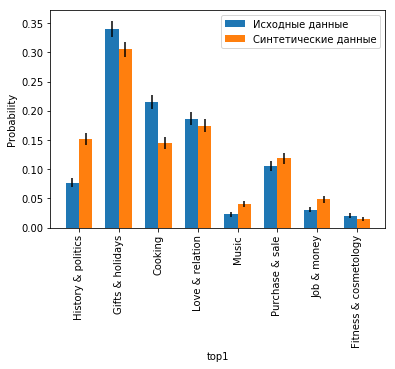

In [23]:
draw_comparative_hist('top1', data_filter, sample)

In [24]:
start = time.time()
bn1 = structure_learning(module1, 'K2', node_type1)


  0%|          | 4/1000000 [00:00<36:19:43,  7.65it/s] 


In [25]:
bn1

{'V': ['age',
  'sex',
  'has_high_education',
  'relation_status',
  'number_of_relatives'],
 'E': [['age', 'sex'],
  ['has_high_education', 'number_of_relatives'],
  ['has_high_education', 'age'],
  ['relation_status', 'has_high_education'],
  ['relation_status', 'age']]}

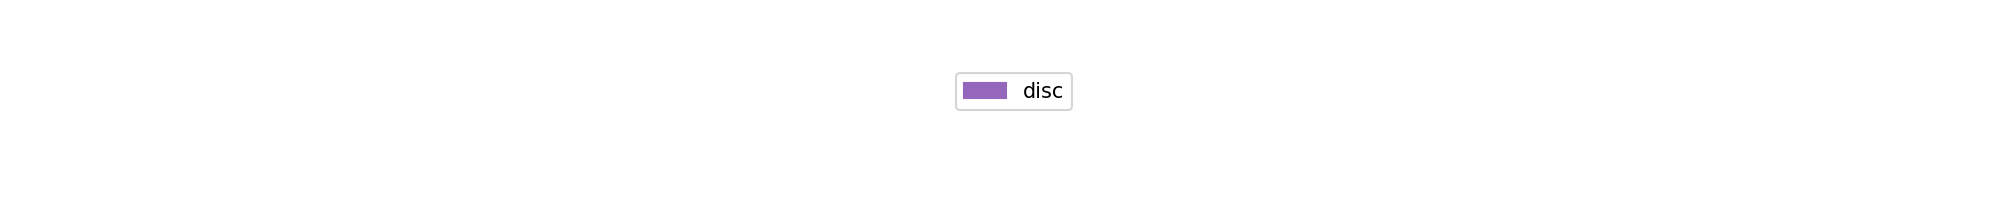

In [26]:
visualizer(bn1, node_type1, 'module1')

In [27]:
#param1 = parameter_learning(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']], node_type1, bn1)

In [28]:
# save_structure(bn1, 'skel1')
# skel1 = read_structure('skel1')
# save_params(param1, 'params1')
# params1 = read_params('params1')
# hybn1 = HyBayesianNetwork(skel1, params1)

In [29]:
end = time.time()
print(end - start)

1.098844051361084


In [30]:
bn2 = structure_learning(module2, 'K2', node_type2)


  0%|          | 3/1000000 [00:00<49:27:19,  5.62it/s]

In [31]:
bn2

{'V': ['len_of_about',
  'number_of_activities',
  'number_of_books',
  'number_of_interests',
  'number_of_movies'],
 'E': [['number_of_activities', 'number_of_interests'],
  ['number_of_activities', 'len_of_about'],
  ['number_of_interests', 'number_of_movies'],
  ['number_of_movies', 'number_of_books']]}

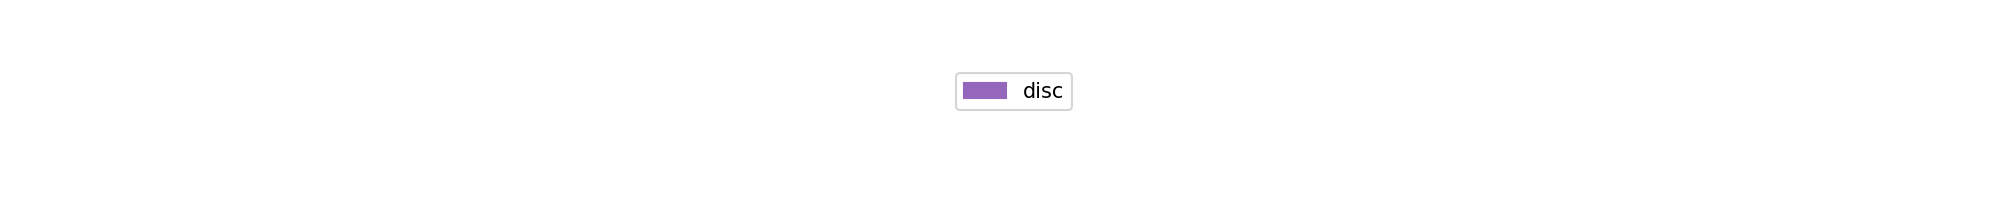

In [32]:
visualizer(bn2, node_type2, 'module2')

In [33]:
#param2 = parameter_learning(data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']], node_type2, bn2)

In [34]:
# save_structure(bn2, 'skel2')
# skel2 = read_structure('skel2')
# save_params(param2, 'params2')
# params2 = read_params('params2')
# hybn2 = HyBayesianNetwork(skel2, params2)


In [35]:
end = time.time()
print(end - start)

2.421198844909668


In [36]:
# node_type_final = {**node_type1, **node_type2}
# hybn_connect = direct_connect([bn1,bn2],new_data, node_type_final)
# hybn_final = direct_train([bn1,bn2], data, hybn_connect)

In [37]:
# end = time.time()
# print(end - start)

In [38]:
bn3 = structure_learning(module3, 'K2', node_type3)
bn3



  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 1/1000000 [00:00<54:10:48,  5.13it/s]

  0%|          | 5/1000000 [00:00<17:06:55, 16.23it/s]



{'V': ['top1', 'top2', 'top3', 'top4'],
 'E': [['top1', 'top2'],
  ['top1', 'top4'],
  ['top1', 'top3'],
  ['top2', 'top4'],
  ['top2', 'top3'],
  ['top3', 'top4']]}

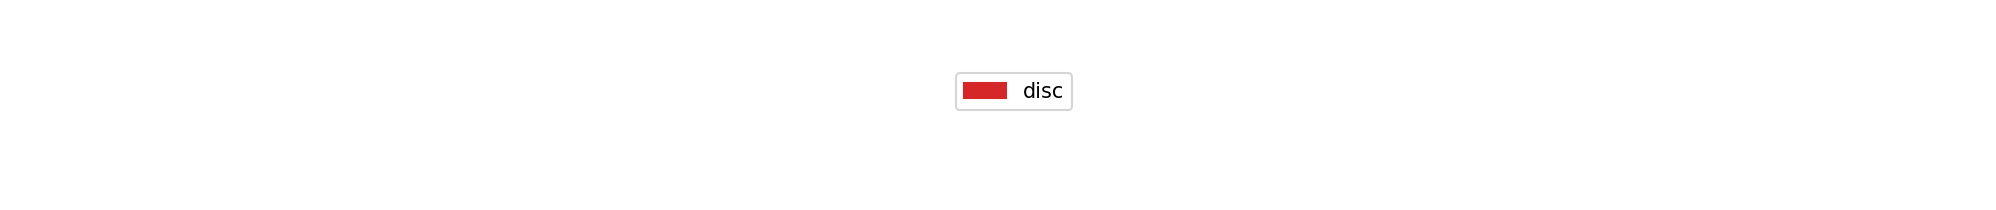

In [39]:
visualizer(bn3, node_type3, 'module3')

In [40]:
#param3 = parameter_learning(data[['top1', 'top2', 'top3', 'top4']], node_type3, bn3)

In [41]:
# save_structure(bn3, 'skel3')
# skel3 = read_structure('skel3')
# save_params(param3, 'params3')
# params3 = read_params('params3')
# hybn3 = HyBayesianNetwork(skel3, params3)

In [42]:
end = time.time()
print(end - start)

3.4464473724365234


In [43]:
# node_type_final = {**node_type1, **node_type2,  **node_type3}
# hybn_connect = direct_connect([bn1,bn2, bn3],new_data, node_type_final)
# hybn_final = direct_train([bn1,bn2, bn3], data, hybn_connect)

In [44]:
# end = time.time()
# print(end - start)

In [45]:
bn4 = structure_learning(module4, 'K2', node_type4)
bn4



  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 1/1000000 [00:00<90:51:41,  3.06it/s]

  0%|          | 3/1000000 [00:00<53:26:28,  5.20it/s]

  0%|          | 5/1000000 [00:00<52:07:30,  5.33it/s]



{'V': ['nodes',
  'betweenness_centrality',
  'eigenvector_centrality',
  'density',
  'degree_assortativity_coefficient'],
 'E': [['nodes', 'degree_assortativity_coefficient'],
  ['nodes', 'density'],
  ['betweenness_centrality', 'density'],
  ['eigenvector_centrality', 'betweenness_centrality'],
  ['degree_assortativity_coefficient', 'eigenvector_centrality'],
  ['degree_assortativity_coefficient', 'betweenness_centrality']]}

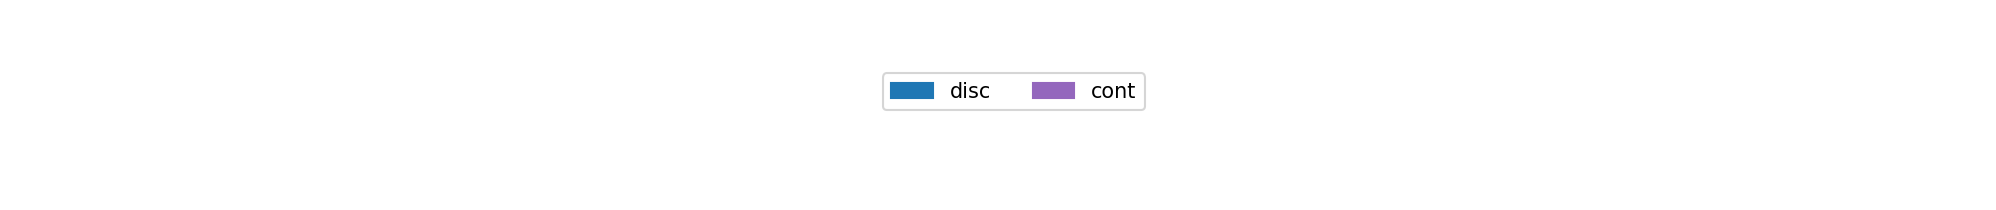

In [46]:
visualizer(bn4, node_type4, 'module4')

In [47]:
# param4 = parameter_learning(data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'density', 'degree_assortativity_coefficient']], node_type4, bn4)

In [48]:
# save_structure(bn4, 'skel4')
# skel4 = read_structure('skel4')
# save_params(param4, 'params4')
# params4 = read_params('params4')
# hybn4 = HyBayesianNetwork(skel4, params4)

In [49]:
end = time.time()
print(end - start)

5.370755910873413


In [50]:
# node_type_final = {**node_type1, **node_type2,  **node_type3, **node_type4}
# hybn_connect = direct_connect([bn1,bn2, bn3, bn4],new_data, node_type_final)
# hybn_final = direct_train([bn1,bn2, bn3, bn4], data, hybn_connect)

In [51]:
# end = time.time()
# print(end - start)

In [52]:
bn5 = structure_learning(module5, 'K2', node_type5)



  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 1/1000000 [00:00<95:34:47,  2.91it/s]

  0%|          | 3/1000000 [00:00<43:20:39,  6.41it/s]

  0%|          | 5/1000000 [00:00<32:10:28,  8.63it/s]

  0%|          | 8/1000000 [00:00<24:43:41, 11.23it/s]

  0%|          | 13/1000000 [00:00<17:41:48, 15.70it/s]



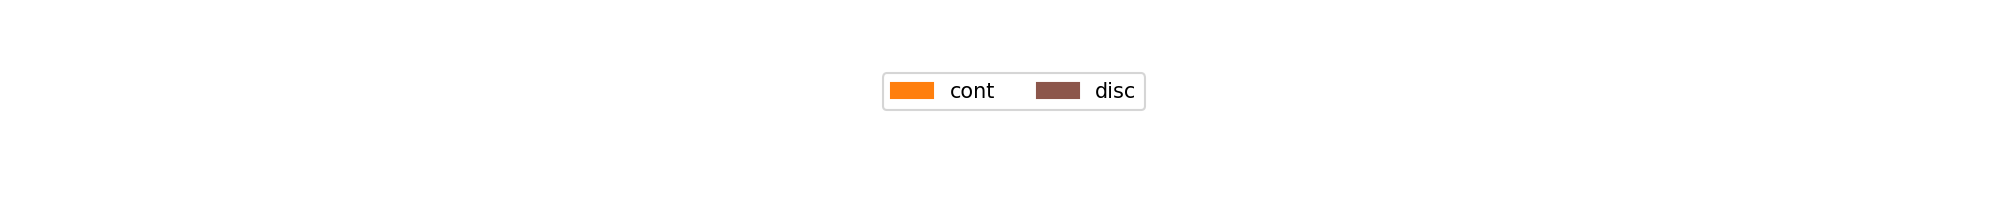

In [53]:
visualizer(bn5, node_type5, 'module5')

In [54]:
#param5 = parameter_learning(data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']], node_type5, bn5)

In [55]:
# save_structure(bn5, 'skel5')
# skel5 = read_structure('skel5')
# save_params(param5, 'params5')
# params5 = read_params('params5')
# hybn5 = HyBayesianNetwork(skel5, params5)

In [56]:
end = time.time()
print(end - start)

6.8917975425720215


In [57]:
# bn6 = structure_learning(module6, 'K2', node_type6)
# bn6

In [58]:
#param6 = parameter_learning(data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']], node_type6, bn6)

In [59]:
# save_structure(bn6, 'skel6')
# skel6 = read_structure('skel6')
# save_params(param6, 'params6')
# params6 = read_params('params6')
# hybn6 = HyBayesianNetwork(skel6, params6)

In [60]:
node_type_final = {**node_type1, **node_type2, **node_type3, **node_type4, **node_type5}

In [61]:
hybn_connect = direct_connect([bn1,bn2, bn3, bn4, bn5],new_data, node_type_final)




  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 1/1000000 [00:15<4282:12:26, 15.42s/it]

  0%|          | 2/1000000 [00:16<2260:26:15,  8.14s/it]

  0%|          | 3/1000000 [00:16<1571:30:37,  5.66s/it]

  0%|          | 4/1000000 [00:17<1221:29:22,  4.40s/it]

  0%|          | 5/1000000 [00:18<1011:35:18,  3.64s/it]

  0%|          | 6/1000000 [00:19<883:38:51,  3.18s/it] 

  0%|          | 7/1000000 [00:20<795:42:53,  2.86s/it]

  0%|          | 8/1000000 [00:20<719:16:34,  2.59s/it]

  0%|          | 9/1000000 [00:21<661:12:48,  2.38s/it]

  0%|          | 10/1000000 [00:22<613:29:05,  2.21s/it]

  0%|          | 11/1000000 [00:22<574:26:03,  2.07s/it]

  0%|          | 12/1000000 [00:23<551:53:40,  1.99s/it]

  0%|          | 13/1000000 [00:24<522:04:18,  1.88s/it]

  0%|          | 14/1000000 [00:25<506:50:57,  1.82s/it]

  0%|          | 15/1000000 [00:26<493:51:36,  1.78s/it]

  0%|          | 16/1000000 [00:27<484:14:55,  1.74s/it]

  0%|          | 17/1000000 

In [62]:
hybns = [bn1,bn2, bn3, bn4, bn5]

In [63]:
hybn_final = direct_train(hybns, data, hybn_connect)

0 1
0 2
0 3
0 4
1 3
4 2
3 2


In [64]:
sample = pd.DataFrame()

In [65]:
for i in range (1000):
    age = np.random.randint(50,71,1)[0]
    evidence = {'age':str(age), 'sex':'1'}
    batch = pd.DataFrame(hybn_final.randomsample(5,evidence))
    sample = pd.concat([sample,batch])

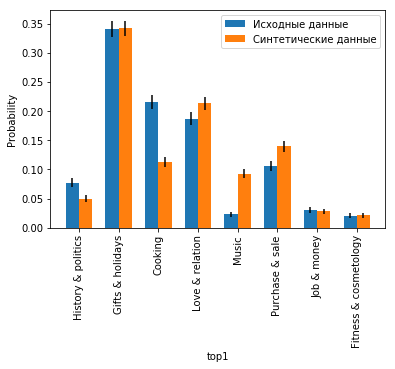

In [66]:
draw_comparative_hist('top1', data_filter, sample)

In [67]:
end = time.time()
print(end - start)

220.57396340370178


In [68]:
final_struct = dict()
final_struct['V'] = hybn_final.V
final_struct['E'] = hybn_final.E

In [69]:
final_struct['V'] 

['relation_status',
 'has_high_education',
 'number_of_relatives',
 'age',
 'sex',
 'L 0_1',
 'number_of_activities',
 'number_of_interests',
 'number_of_movies',
 'number_of_books',
 'len_of_about',
 'L 1_3',
 'L 0_2',
 'L 0_4',
 'cash_usage',
 'parent',
 'driver',
 'has_pets',
 'L 4_2',
 'mean_tr',
 'max_tr',
 'L 0_3',
 'nodes',
 'L 3_2',
 'top1',
 'top2',
 'top3',
 'top4',
 'degree_assortativity_coefficient',
 'eigenvector_centrality',
 'betweenness_centrality',
 'density']

In [70]:
final_struct['E']

[['top1', 'top3'],
 ['driver', 'max_tr'],
 ['number_of_movies', 'number_of_books'],
 ['number_of_activities', 'number_of_interests'],
 ['number_of_relatives', 'L 0_3'],
 ['eigenvector_centrality', 'betweenness_centrality'],
 ['has_pets', 'L 4_2'],
 ['cash_usage', 'mean_tr'],
 ['number_of_relatives', 'L 0_2'],
 ['nodes', 'L 3_2'],
 ['mean_tr', 'max_tr'],
 ['nodes', 'density'],
 ['L 0_1', 'number_of_activities'],
 ['parent', 'max_tr'],
 ['top3', 'top4'],
 ['L 0_2', 'top1'],
 ['top2', 'top3'],
 ['parent', 'driver'],
 ['L 4_2', 'top1'],
 ['sex', 'L 0_1'],
 ['sex', 'L 0_2'],
 ['number_of_relatives', 'L 0_4'],
 ['nodes', 'degree_assortativity_coefficient'],
 ['has_pets', 'mean_tr'],
 ['degree_assortativity_coefficient', 'betweenness_centrality'],
 ['cash_usage', 'driver'],
 ['top1', 'top2'],
 ['number_of_relatives', 'L 0_1'],
 ['has_high_education', 'number_of_relatives'],
 ['sex', 'L 0_4'],
 ['parent', 'has_pets'],
 ['parent', 'L 4_2'],
 ['top2', 'top4'],
 ['age', 'sex'],
 ['cash_usage', 'p

In [71]:
node_type_final['L 0_1'] = 'disc'
node_type_final['L 0_3'] = 'disc'
node_type_final['L 0_4'] = 'disc'
node_type_final['L 0_2'] = 'disc'
node_type_final['L 2_4'] = 'disc'
node_type_final['L 2_0'] = 'disc'
node_type_final['L 4_2'] = 'disc'
node_type_final['L 3_0'] = 'disc'
node_type_final['L 1_0'] = 'disc'
node_type_final['L 1_3'] = 'disc'
node_type_final['L 3_2'] = 'disc'

In [72]:
node_type_final

{'age': 'disc',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation_status': 'disc',
 'number_of_relatives': 'disc',
 'len_of_about': 'disc',
 'number_of_activities': 'disc',
 'number_of_books': 'disc',
 'number_of_interests': 'disc',
 'number_of_movies': 'disc',
 'top1': 'disc',
 'top2': 'disc',
 'top3': 'disc',
 'top4': 'disc',
 'nodes': 'disc',
 'betweenness_centrality': 'cont',
 'eigenvector_centrality': 'cont',
 'density': 'cont',
 'degree_assortativity_coefficient': 'cont',
 'max_tr': 'cont',
 'mean_tr': 'cont',
 'parent': 'disc',
 'driver': 'disc',
 'has_pets': 'disc',
 'cash_usage': 'disc',
 'L 0_1': 'disc',
 'L 0_3': 'disc',
 'L 0_4': 'disc',
 'L 0_2': 'disc',
 'L 2_4': 'disc',
 'L 2_0': 'disc',
 'L 4_2': 'disc',
 'L 3_0': 'disc',
 'L 1_0': 'disc',
 'L 1_3': 'disc',
 'L 3_2': 'disc'}

In [76]:
final_struct

{'V': ['relation_status',
  'has_high_education',
  'number_of_relatives',
  'age',
  'sex',
  'L 0_1',
  'number_of_activities',
  'number_of_interests',
  'number_of_movies',
  'number_of_books',
  'len_of_about',
  'L 1_3',
  'L 0_2',
  'L 0_4',
  'cash_usage',
  'parent',
  'driver',
  'has_pets',
  'L 4_2',
  'mean_tr',
  'max_tr',
  'L 0_3',
  'nodes',
  'L 3_2',
  'top1',
  'top2',
  'top3',
  'top4',
  'degree_assortativity_coefficient',
  'eigenvector_centrality',
  'betweenness_centrality',
  'density'],
 'E': [['top1', 'top3'],
  ['driver', 'max_tr'],
  ['number_of_movies', 'number_of_books'],
  ['number_of_activities', 'number_of_interests'],
  ['number_of_relatives', 'L 0_3'],
  ['eigenvector_centrality', 'betweenness_centrality'],
  ['has_pets', 'L 4_2'],
  ['cash_usage', 'mean_tr'],
  ['number_of_relatives', 'L 0_2'],
  ['nodes', 'L 3_2'],
  ['mean_tr', 'max_tr'],
  ['nodes', 'density'],
  ['L 0_1', 'number_of_activities'],
  ['parent', 'max_tr'],
  ['top3', 'top4'],
  [

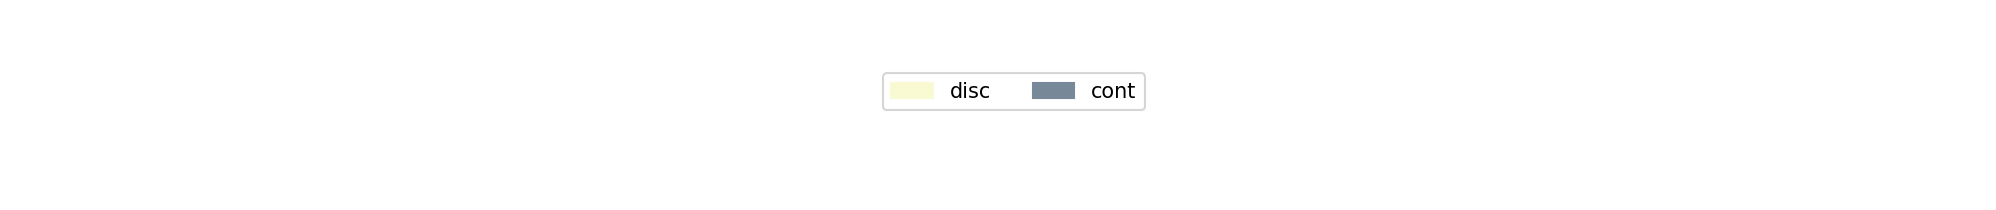

In [75]:
visualizer(final_struct, node_type_final, 'final_net')